# Check-GPU-Connect

In [1]:
print("auto connect")

auto connect


In [2]:
import tensorflow as tf
print(tf.__version__)

import torch
print(torch.__version__)  # Should show the PyTorch version
print(torch.version.cuda)  # Should show the CUDA version
print(torch.cuda.is_available())  # Should return True if the GPU is available

# Check if GPU is available
if torch.cuda.is_available():
    print("GPU is available")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("GPU is not available")

2.16.1
2.4.0
12.3
True
GPU is available
Number of GPUs: 2
GPU Name: Tesla T4


# Data-get-home

In [3]:
!git clone https://github.com/QuanHoangNgoc/Data-home.git Data-home

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Cloning into 'Data-home'...
remote: Enumerating objects: 3268, done.
remote: Counting objects: 100% (3268/3268), done.
remote: Compressing objects: 100% (3266/3266), done.
remote: Total 3268 (delta 0), reused 3268 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3268/3268), 27.56 MiB | 32.66 MiB/s, done.


# Content

In [4]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Flatten
from tensorflow.keras.models import Sequential

def get_hypo_network(wide_in, num_out, freeze=False):
    # Load pre-trained MobileNetV2 without the top classification layer
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(wide_in, wide_in, 3))
    glp = GlobalAveragePooling2D()
    flat = Flatten()
    # Add custom classification layers
    custom = Sequential([Dense(1024, activation='relu'),
        Dropout(rate=0.3),
        Dense(512, activation='relu'),
        Dropout(rate=0.25)])
    predictor = Dense(num_out, activation='softmax')

    # Freeze the layers of the pre-trained model
    if(freeze):
        for layer in base_model.layers: layer.trainable = False

    # Create the model
    x = base_model.output
    x = glp(x)
    x = flat(x)
    x = custom(x)
    y = predictor(x)
    network = tf.keras.models.Model(inputs=base_model.input, outputs=y)

    # Print the model summary
    network.summary()
    return network

In [5]:
def compile_network(network, lr=1e-4):
    algo = tf.keras.optimizers.Adam(learning_rate=lr)
    network.compile(optimizer=algo, loss='categorical_crossentropy', metrics=['accuracy', 'recall', 'precision'])
    network.summary()
    return network

In [6]:
import datetime, os
from tensorflow.keras.callbacks import ModelCheckpoint


def get_checkpoint():
    now = datetime.datetime.now()
    day = now.day
    hour = now.hour
    minute = now.minute
    second = now.second
    ip_cp = f"{day}.{hour}.{minute}.{second}"
    print(ip_cp, flush=True)
    path = os.path.join(os.getcwd(), 'CP', f"best-model-{ip_cp}.keras")
    return ModelCheckpoint(path,
        monitor='val_accuracy',
        save_best_only=True, mode='max',
        verbose=1)


def fit_network(network, gen_train, ep, gen_val):
    cp = get_checkpoint()
    history = network.fit(gen_train, epochs=ep, validation_data=gen_val, shuffle=False, callbacks=[cp])
    return history

In [7]:
net = get_hypo_network(224, 10)
net = compile_network(net)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 4,099,658 (15.64 MB)

 Trainable params: 4,065,546 (15.51 MB)

 Non-trainable params: 34,112 (133.25 KB)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 4,099,658 (15.64 MB)

 Trainable params: 4,065,546 (15.51 MB)

 Non-trainable params: 34,112 (133.25 KB)

## Provide metadata

In [24]:
def format_path(path): 
    path = path.replace("/content/", "/kaggle/working/")
    path = path.replace("\\", "/")
    return path

In [17]:
FOLDER = format_path("/content/Data-home/MY_data/train") 

In [18]:
NAME_LABELS = [x.lower() for x in sorted(set(os.listdir(FOLDER)))]
NAME_LABELS

['apple',
 'banana',
 'avocado',
 'cherry',
 'kiwi',
 'mango',
 'orange',
 'pinenapple',
 'strawberries',
 'watermelon']

In [19]:
import pandas as pd
import re


def get_metadata(root_folder):
    paths = []
    folders = []
    labels = []
    for dirpath, dirnames, filenames in sorted(os.walk(root_folder)): #!!! must sorted
        for file in filenames:
            fullpath = os.path.join(dirpath, file)
            fullpath = fullpath.replace("\\", "/")
            paths.append(fullpath)

            folder = fullpath.split("/")[-2]
            folder = folder.lower()
            folders.append(folder)

            label = NAME_LABELS.index(folder)
            labels.append(str(label))

    # print(paths, folders)
    meta = pd.DataFrame({'path': paths, 'folder': folders, 'y': labels})
    return meta

## Provide DataGenor

In [20]:
def get_genset(metadata, wide_img, bs, val_mode=False):
    genor_train = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255, #!!!
        horizontal_flip=True,
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0)

    genor_val = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255)

    if(val_mode):
        genor = genor_val
        shuff = False
    else:
        genor = genor_train
        shuff = True

    return genor.flow_from_dataframe(
        dataframe=metadata,
        x_col='path',
        y_col='y',
        target_size=(wide_img, wide_img),
        batch_size=bs,
        class_mode='categorical',
        shuffle=shuff)

## Run Script

In [25]:
_meta1 = format_path("/content/Data-home/MY_data/train")
_meta1 = get_metadata(_meta1)
_meta2 = format_path("/content/Data-home/MY_data/test")
_meta2 = get_metadata(_meta2)
meta = result = pd.concat([_meta1, _meta2], ignore_index=True)
meta

,path,folder,y
0,/kaggle/working/Data-home/MY_data/train/Apple/...,apple,0
1,/kaggle/working/Data-home/MY_data/train/Apple/...,apple,0
2,/kaggle/working/Data-home/MY_data/train/Apple/...,apple,0
3,/kaggle/working/Data-home/MY_data/train/Apple/...,apple,0
4,/kaggle/working/Data-home/MY_data/train/Apple/...,apple,0
...,...,...,...
3321,/kaggle/working/Data-home/MY_data/test/waterme...,watermelon,9
3322,/kaggle/working/Data-home/MY_data/test/waterme...,watermelon,9
3323,/kaggle/working/Data-home/MY_data/test/waterme...,watermelon,9
3324,/kaggle/working/Data-home/MY_data/test/waterme...,watermelon,9


In [26]:
from sklearn.model_selection import train_test_split

# Split the dataset into train+val and test sets first
meta_train, _temp = train_test_split(meta, test_size=0.2, random_state=42)
# Now split the remaining dataset into train and val sets
meta_val, meta_test = train_test_split(_temp, test_size=0.25, random_state=42)

In [27]:
gen_train = get_genset(meta_train, 224, 32)
gen_val = get_genset(meta_val, 224, 32, val_mode=True)
gen_test = get_genset(meta_test, 224, 32, val_mode=True)

Found 2660 validated image filenames belonging to 10 classes.
Found 499 validated image filenames belonging to 10 classes.
Found 167 validated image filenames belonging to 10 classes.


In [28]:
network = get_hypo_network(224, 10)
network = compile_network(network)
# history = fit_network(network, gen_train, 10, gen_val) #~lock 

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 4,099,658 (15.64 MB)

 Trainable params: 4,065,546 (15.51 MB)

 Non-trainable params: 34,112 (133.25 KB)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 4,099,658 (15.64 MB)

 Trainable params: 4,065,546 (15.51 MB)

 Non-trainable params: 34,112 (133.25 KB)

29.4.22.0
Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1724905346.060392     136 service.cc:145] XLA service 0x7df598002370 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724905346.060458     136 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1724905346.060464     136 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/84 ━━━━━━━━━━━━━━━━━━━━ 1:10:32 51s/step - accuracy: 0.1250 - loss: 2.4450 - precision: 1.0000 - recall: 0.0625

I0000 00:00:1724905372.270090     136 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 644ms/step - accuracy: 0.4147 - loss: 1.7620 - precision: 0.9095 - recall: 0.1528

I0000 00:00:1724905425.766398     136 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_1', 248 bytes spill stores, 248 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_2', 24 bytes spill stores, 24 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_and_reduce_fusion', 284 bytes spill stores, 292 bytes spill loads




Epoch 1: val_accuracy improved from -inf to 0.79158, saving model to /kaggle/working/CP/best-model-29.4.22.0.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 112s 739ms/step - accuracy: 0.4172 - loss: 1.7553 - precision: 0.9095 - recall: 0.1555 - val_accuracy: 0.7916 - val_loss: 0.6694 - val_precision: 0.8500 - val_recall: 0.7495
Epoch 2/10
83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step - accuracy: 0.8833 - loss: 0.4034 - precision: 0.9186 - recall: 0.8324
Epoch 2: val_accuracy improved from 0.79158 to 0.81162, saving model to /kaggle/working/CP/best-model-29.4.22.0.keras
84/84 ━━━━━━━━━━━━━━━━━━━━ 35s 413ms/step - accuracy: 0.8836 - loss: 0.4025 - precision: 0.9187 - recall: 0.8330 - val_accuracy: 0.8116 - val_loss: 0.6072 - val_precision: 0.8369 - val_recall: 0.7916
Epoch 3/10
83/84 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step - accuracy: 0.9348 - loss: 0.1937 - precision: 0.9522 - recall: 0.9216
Epoch 3: val_accuracy improved from 0.81162 to 0.84369, saving model to /kaggle/working/CP/best-model-29.4.22.0.keras
8

## Load the-best and testing

In [30]:
best_net = tf.keras.models.load_model(format_path('/kaggle/working/CP/best-model-29.4.22.0.keras'))

In [31]:
best_net.evaluate(gen_test) 

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 584ms/step - accuracy: 0.9200 - loss: 0.2263 - precision: 0.9268 - recall: 0.9174


[0.30265527963638306, 0.916167676448822, 0.910179615020752, 0.9212121367454529]

In [36]:
print(gen_test.classes)
gen_test.classes[0] 

[4, 6, 2, 5, 3, 2, 3, 1, 3, 0, 0, 9, 4, 5, 1, 3, 7, 9, 1, 1, 0, 4, 4, 1, 2, 4, 2, 1, 1, 6, 3, 1, 5, 4, 2, 6, 3, 3, 8, 5, 1, 3, 0, 3, 6, 3, 3, 4, 5, 0, 3, 8, 2, 2, 3, 5, 2, 1, 7, 3, 5, 1, 9, 6, 7, 4, 6, 9, 8, 3, 3, 8, 7, 3, 4, 3, 4, 1, 7, 4, 1, 2, 1, 0, 1, 8, 1, 1, 1, 4, 8, 3, 3, 4, 9, 0, 0, 4, 1, 7, 6, 5, 8, 4, 8, 1, 3, 4, 6, 5, 0, 3, 8, 6, 4, 4, 8, 7, 2, 0, 7, 0, 5, 9, 8, 3, 0, 5, 7, 9, 4, 7, 1, 0, 6, 8, 7, 3, 5, 8, 2, 2, 0, 9, 2, 4, 2, 1, 3, 6, 8, 8, 6, 2, 2, 4, 2, 1, 8, 0, 4, 7, 8, 3, 7, 8, 8]


4

In [39]:
best_net.predict(gen_test).shape 

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


(167, 10)

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 524ms/step


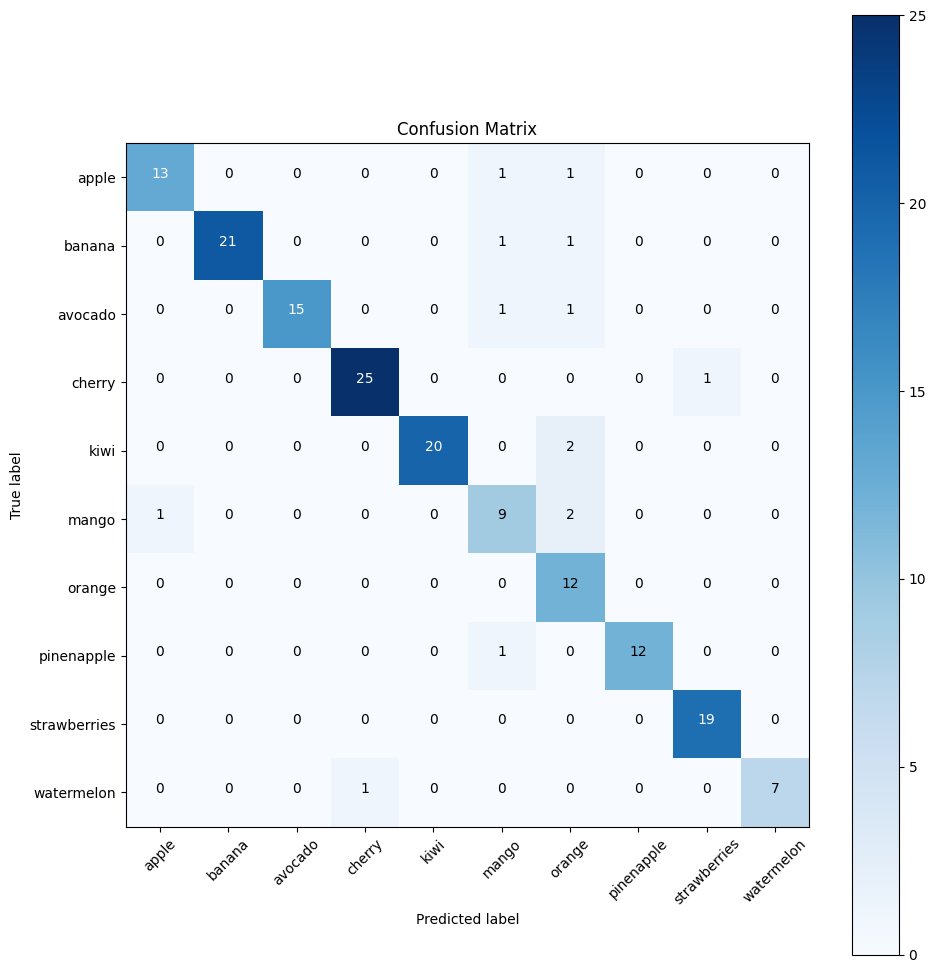

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

# Get the true labels and predictions
y_true = gen_test.classes
y_pred = np.argmax(best_net.predict(gen_test), axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(NAME_LABELS))
plt.xticks(tick_marks, NAME_LABELS, rotation=45)
plt.yticks(tick_marks, NAME_LABELS)
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Add labels to each cell
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.show()

## Predict System 

In [58]:
class PredictSystem:
    def __init__(self, link_network): 
        print(f"Link network: {link_network}")
        self.network = tf.keras.models.load_model(link_network)

    def _get_genset(self, metadata, wide_img, bs):  
        genor = tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255)
        shuff = False 
        return genor.flow_from_dataframe(
            dataframe=metadata,
            x_col='path',
            y_col='y',
            target_size=(wide_img, wide_img),
            batch_size=bs,
            class_mode='categorical',
            shuffle=shuff)
        

    def predict(self, image_path):
        plt.figure(figsize=(10, 5))
        img = plt.imread(image_path)
        plt.imshow(img)
        plt.show()
        
        metadata = pd.DataFrame({'path': [image_path], 'y': ["*"]})
        genset = self._get_genset(metadata, 224, 1)
        y = self.network.predict(genset)[0] 
        class_predict = NAME_LABELS[np.argmax(y)] 
        print(f"Class is predicted is: {class_predict}")
        
        # Create a bar chart
        print(y, flush=True)
        plt.figure(figsize=(10, 5))
        plt.bar(NAME_LABELS, y)
        plt.title('Prediction Probabilities')
        plt.xlabel('Classes')
        plt.ylabel('Probability')
        plt.xticks(rotation=45)
        plt.show()
        

In [59]:
system = PredictSystem(format_path('/kaggle/working/CP/best-model-29.4.22.0.keras'))

Link network: /kaggle/working/CP/best-model-29.4.22.0.keras


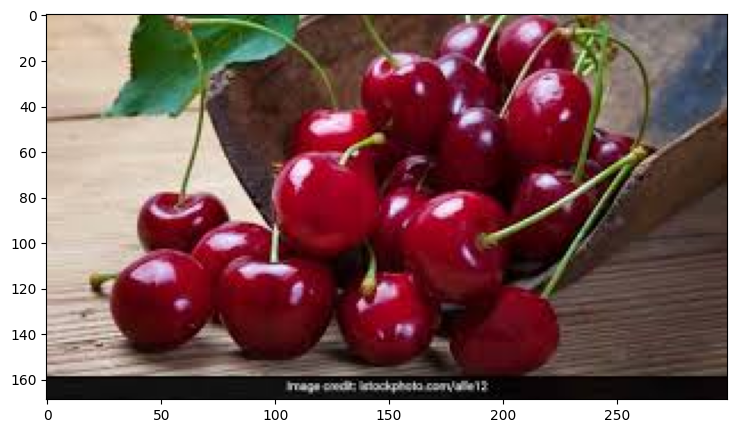

Found 1 validated image filenames belonging to 1 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Class is predicted is: cherry
[9.9538884e-09 9.2373706e-11 6.7499431e-12 1.0000000e+00 6.1579353e-11
 2.5687725e-11 1.6415138e-11 1.2793174e-11 1.7695025e-10 1.9619912e-11]


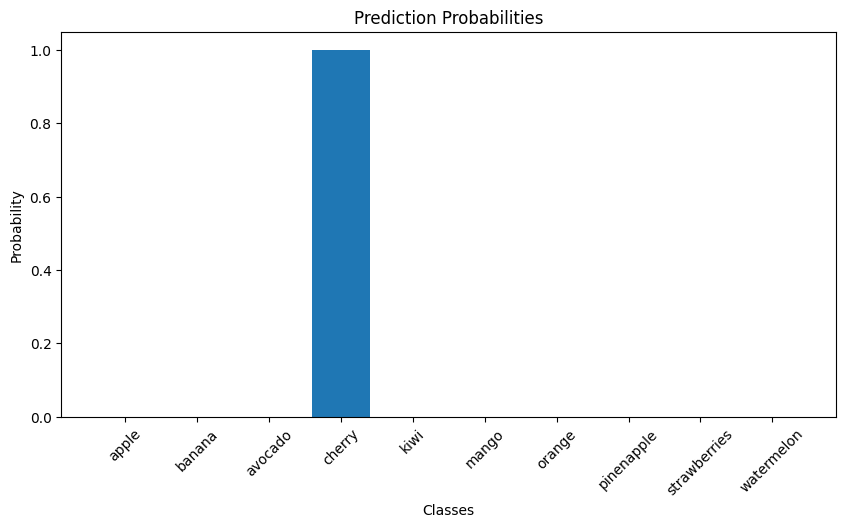

In [60]:
system.predict(format_path("/kaggle/working/Data-home/MY_data/predict/65.jpeg"))

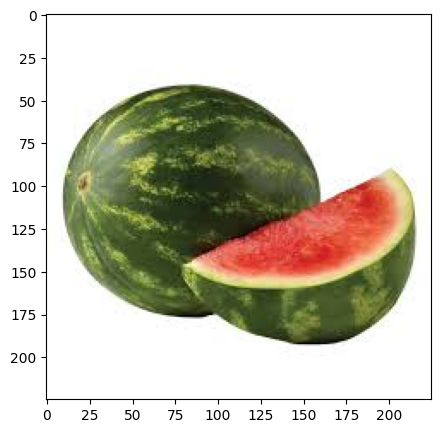

Found 1 validated image filenames belonging to 1 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Class is predicted is: watermelon
[1.5627832e-07 2.8283882e-11 8.1991032e-11 1.4964194e-09 9.3615402e-12
 2.6350598e-08 1.3655753e-09 2.3536346e-11 4.9499199e-10 9.9999976e-01]


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


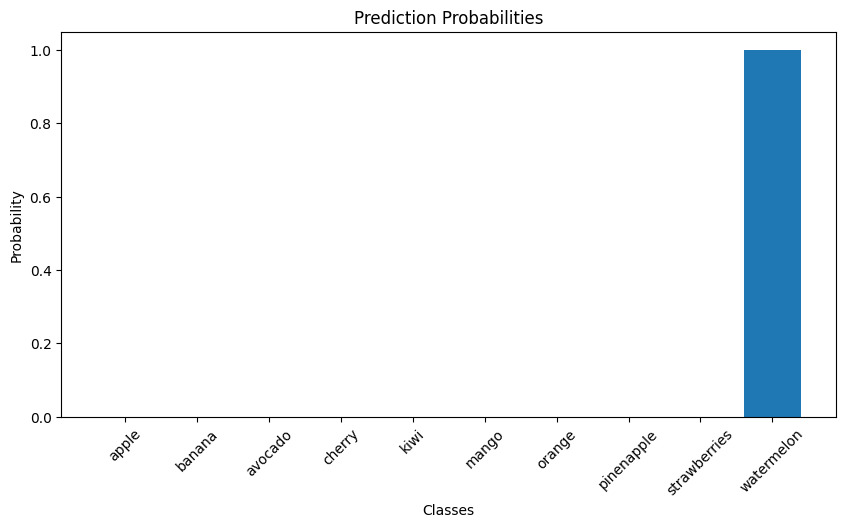

In [61]:
system.predict(format_path("/kaggle/working/Data-home/MY_data/predict/023.jpeg"))